In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import osmnx as ox
import networkx as nx
import ast
from shapely import wkt

TIME_INTERVAL = '1H'

# Load INRIX speed data and conversion data
inrix_df = pd.read_csv('../data/Hamilton-County-INRIX.csv')
conversion_df = pd.read_csv('../data/XD_Identification.csv')

ms_buildings = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/county_buildings_MS.csv')
ms_buildings['location'] = ms_buildings['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
ms_buildings_locations = list(ms_buildings['location'].apply(tuple).unique())

## Load ODs

In [2]:
desired_date = pd.Timestamp("2025-03-10 01:00:00").date()
inrix_df["measurement_tstamp"] = pd.to_datetime(inrix_df["measurement_tstamp"])
inrix_df = inrix_df[inrix_df["measurement_tstamp"].dt.date == desired_date]

In [3]:
od_df = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/lodes_combs/lodes_2024-03-23.csv')

od_pairs = []
for _, row in od_df.iterrows():
    orig_dep = pd.Timestamp(row['departure_time'])
    # snap to 2‑hour bins
    dep_time = orig_dep.floor(TIME_INTERVAL)
    time_str = dep_time.strftime('%H:%M:%S')

    od_pairs.append({
        "origin":             (row['origin_loc_lat'], row['origin_loc_lon']),
        "destination":        (row['dest_loc_lat'], row['dest_loc_lon']),
        "departure_time":     pd.Timestamp(f"{desired_date} {time_str}"),
        "possible_dest_loc":  row['possible_dest_loc']
    })

In [4]:
hourly_inrix_df = (inrix_df
    .set_index('measurement_tstamp')
    .groupby('xd_id')
    .resample(TIME_INTERVAL)  # now resample every 30 minutes instead of hourly
    .agg({
        'speed': 'mean',
        'historical_average_speed': 'mean',
        'reference_speed': 'mean',
        'travel_time_minutes': 'mean',
        'confidence_score': 'mean',
        'cvalue': 'mean'
    })
    .reset_index()
)

# Format the result
hourly_inrix_df = hourly_inrix_df.round(2)  # Round to 2 decimal places

# Extract all unique hourly timestamps
all_hours = hourly_inrix_df["measurement_tstamp"].drop_duplicates().sort_values()

In [5]:
import collections

hourly_graphs = {}  # Store G_hour per timestamp

for hour in all_hours:
    # Filter INRIX for this hour
    inrix_snapshot = hourly_inrix_df[hourly_inrix_df["measurement_tstamp"] == hour]
    
    # Merge with conversion
    merged_df = pd.merge(inrix_snapshot, conversion_df, left_on="xd_id", right_on="xd")
    
    # Create LineStrings
    geometries = [
        LineString([(x1, y1), (x2, y2)])
        for x1, y1, x2, y2 in zip(merged_df["start_longitude"], merged_df["start_latitude"],
                                 merged_df["end_longitude"], merged_df["end_latitude"])
    ]
    inrix_gdf = gpd.GeoDataFrame(merged_df, geometry=geometries, crs="EPSG:4326")
    
    # Fetch OSM network only once (outside loop for efficiency)
    if 'G_base' not in locals():
        # Use the maximum bounds from od_df by combining origin and destination coordinates
        # minx = min(od_df["origin_loc_lon"].min(), od_df["dest_loc_lon"].min())
        # miny = min(od_df["origin_loc_lat"].min(), od_df["dest_loc_lat"].min())
        # maxx = max(od_df["origin_loc_lon"].max(), od_df["dest_loc_lon"].max())
        # maxy = max(od_df["origin_loc_lat"].max(), od_df["dest_loc_lat"].max())
        # minx, miny, maxx, maxy = minx - 0.5, miny - 0.5, maxx + 0.5, maxy + 0.5

        G_base = ox.graph_from_place("Hamilton County, TN, USA", network_type="drive")
        edges_base = ox.graph_to_gdfs(G_base, nodes=False, edges=True).to_crs(epsg=3857)
        
    # Project INRIX and join to edges
    inrix_proj = inrix_gdf.to_crs(epsg=3857)
    joined = gpd.sjoin_nearest(inrix_proj, edges_base, how="left", distance_col="dist")

    # Clone graph
    G_hour = G_base.copy()

    # Update edge weights in G_hour
    for idx, row in joined.iterrows():
        u, v, key = row["index_right0"], row["index_right1"], row["index_right2"]
        speed = row["speed"]
        length = row["length"]
        if pd.notnull(speed) and speed > 0:
            travel_time = (3.6 * length) / speed
            G_hour[u][v][key]["travel_time"] = travel_time
            G_hour[u][v][key]["weight"] = travel_time

    # Assign default weights to zero/None weights
    default_speed_kmh = 80
    for u, v, k, data in G_hour.edges(keys=True, data=True):
        weight = data.get("weight", None)
        if (weight == 0) or (weight is None):
            length = data.get("length", None)
            if length:
                travel_time = (3.6 * length) / default_speed_kmh
                data["weight"] = travel_time

    # Store graph
    hourly_graphs[hour] = G_hour


In [6]:
from tqdm.notebook import tqdm

# Find any graphs where one or more edges lack a 'weight' attribute
graphs_missing_weight = []

for hr, G in tqdm(hourly_graphs.items(),
                  total=len(hourly_graphs),
                  desc="Checking graphs for missing 'weight'"):
    # Stop at first missing edge
    if any('weight' not in data for _, _, data in G.edges(data=True)):
        graphs_missing_weight.append(hr)

if graphs_missing_weight:
    print("Graphs missing 'weight' attribute:", graphs_missing_weight)
else:
    print("All graphs have a 'weight' attribute on every edge.")

Checking graphs for missing 'weight':   0%|          | 0/24 [00:00<?, ?it/s]

All graphs have a 'weight' attribute on every edge.


In [7]:
G_0 = list(hourly_graphs.values())[0]
origins_lon = list(od_df['origin_loc_lon'].values)
origins_lat = list(od_df['origin_loc_lat'].values)
destinations_lon = list(od_df['dest_loc_lon'].values)
destinations_lat = list(od_df['dest_loc_lat'].values)
od_indices = list(od_df.index)

origins_nodes = ox.distance.nearest_nodes(G_0, X=origins_lon, Y=origins_lat)
destinations_nodes = ox.distance.nearest_nodes(G_0, X=destinations_lon, Y=destinations_lat)

od_df['origin_node'] = origins_nodes
od_df['destination_node'] = destinations_nodes

## All origin, dest locations

In [8]:
# ## uses MS buildings data

# origin_locs = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/county_residential_buildings.csv')
# origin_locs['intpt'] = origin_locs['intpt'].apply(
#     lambda x: (wkt.loads(x).y, wkt.loads(x).x) if isinstance(x, str) else (x.y, x.x)
# )
# origin_locs['location'] = origin_locs['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# origins = origin_locs['location'].unique().tolist() + origin_locs['intpt'].unique().tolist() + ms_buildings_locations
# origins = list(set(origins))


# dest_locs = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/county_work_locations.csv')
# dest_locs['geometry'] = dest_locs['geometry'].apply(
#     lambda x: (wkt.loads(x).y, wkt.loads(x).x) if isinstance(x, str) else (x.y, x.x)
# )
# dest_locs['intpt'] = dest_locs['intpt'].apply(
#     lambda x: (wkt.loads(x).y, wkt.loads(x).x) if isinstance(x, str) else (x.y, x.x)
# )

# dests = dest_locs['geometry'].unique().tolist() + list(dest_locs['intpt'].unique()) + ms_buildings_locations
# dests = list(set(dests))

In [9]:
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm
import ast

def process_chunk(args):
    chunk_df, _ = args
    origins, dests = [], []
    for _, row in chunk_df.iterrows():
        origins.extend(ast.literal_eval(row['possible_home_loc']))
        dests.extend(ast.literal_eval(row['possible_dest_loc']))
    return origins, dests, len(chunk_df)

def parallelize_processing(od_df, num_processes=None):
    if num_processes is None:
        num_processes = mp.cpu_count()
    pbar = tqdm(total=len(od_df), desc="Processing rows")
    # split into chunks
    num_chunks = num_processes * 4
    chunk_size = max(1, len(od_df) // num_chunks)
    chunks = [(od_df.iloc[i:i+chunk_size], i)
              for i in range(0, len(od_df), chunk_size)]

    all_origins, all_dests = [], []
    def _callback(res):
        origins, dests, count = res
        all_origins.extend(origins)
        all_dests.extend(dests)
        pbar.update(count)

    with mp.Pool(processes=num_processes) as pool:
        for chunk_args in chunks:
            pool.apply_async(process_chunk, args=(chunk_args,), callback=_callback)
        pool.close()
        pool.join()
    pbar.close()

    # dedupe and return lists of tuples
    possible_origins = list({tuple(o) for o in all_origins})
    possible_dests   = list({tuple(d) for d in all_dests})
    return possible_origins, possible_dests

# Usage:
od_df = od_df.drop_duplicates(subset=['possible_home_loc', 'possible_dest_loc'])
origins, dests = parallelize_processing(od_df)

Processing rows:   0%|          | 0/24753 [00:00<?, ?it/s]

In [10]:
G_0 = list(hourly_graphs.values())[0]
origin_lons = [p[1] for p in origins]
origin_lats = [p[0] for p in origins]
destination_lons = [p[1] for p in dests]
destination_lats = [p[0] for p in dests]

origin_nodes = ox.distance.nearest_nodes(G_0, X=origin_lons, Y=origin_lats)
destination_nodes = ox.distance.nearest_nodes(G_0, X=destination_lons, Y=destination_lats)

origin_loc_to_node = {loc: node for loc, node in zip(origins, origin_nodes)}
dest_loc_to_node = {loc: node for loc, node in zip(dests, destination_nodes)}

origin_nodes = list(set(origin_nodes))
destination_nodes = list(set(destination_nodes))

In [11]:
def map_locations_to_nodes(locations, loc_to_node):
    """
    Map a list of locations to their corresponding nodes.
    """
    locations = ast.literal_eval(locations) if isinstance(locations, str) else locations
    res = []
    for loc in locations:
        loc_tuple = tuple(loc)  # Ensure loc is a tuple (hashable)
        res.append(loc_to_node[loc_tuple])
    return res

od_df['possible_home_nodes'] = od_df['possible_home_loc'].apply(
    lambda x: map_locations_to_nodes(x, origin_loc_to_node)
)
od_df['possible_dest_nodes'] = od_df['possible_dest_loc'].apply(
    lambda locs: map_locations_to_nodes(locs, dest_loc_to_node)
)

In [12]:
subset_nodes = set(origin_nodes) | set(destination_nodes)
subset_pts = set(origins) | set(dests)

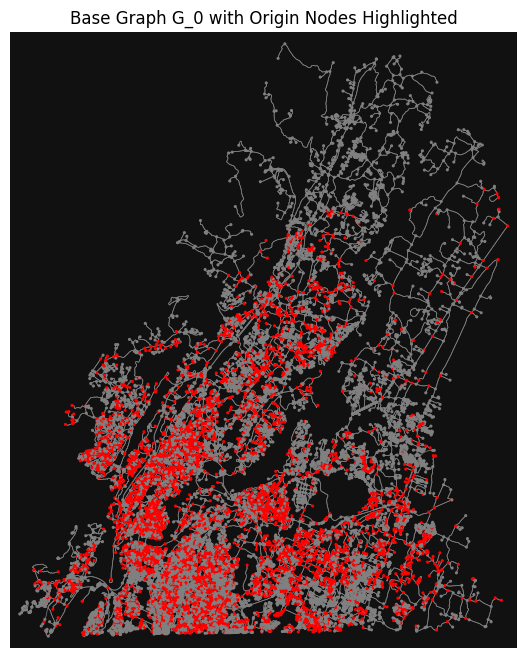

In [13]:
import matplotlib.pyplot as plt
import osmnx as ox

map = G_0
# Create a color map for nodes
node_colors = ['red' if node in subset_nodes else 'gray' for node in map.nodes]

# Plot G_0 with colored nodes
fig, ax = ox.plot_graph(
    map,
    figsize=(8, 8),
    node_size=5,
    node_color=node_colors,
    edge_color='gray',
    edge_linewidth=0.5,
    show=False
)
ax.set_title("Base Graph G_0 with Origin Nodes Highlighted")
plt.show()

## Routing

In [107]:

def process_od_pair(od):
    """Process a single OD pair and return the routing result"""
    orig_node, dest_node, dep_time = od
    
    if isinstance(dep_time, int):
        Exception("int dep_time")
    # Find closest hour
    hour_to_use = dep_time.floor(TIME_INTERVAL)
    G_hour = hourly_graphs.get(hour_to_use)
    if G_hour is None:
        return None  # Skip if no graph is available for this time

    # # Find nearest nodes
    # orig_node = ox.distance.nearest_nodes(G_hour, X=origin_lon, Y=origin_lat)
    # dest_node = ox.distance.nearest_nodes(G_hour, X=dest_lon, Y=dest_lat)

    # Compute shortest path
    try:
        route = nx.shortest_path(G_hour, source=orig_node, target=dest_node, weight="weight")
        # Sum travel time
        total_travel_time_sec = sum(G_hour[u][v][0].get("weight", 0) for u, v in zip(route[:-1], route[1:]))
        
        # Calculate total distance in meters, then convert to miles
        total_distance_m = sum(G_hour[u][v][0].get("length", 0) for u, v in zip(route[:-1], route[1:]))
        total_distance_mi = total_distance_m * 0.000621371  # Convert meters to miles
        
        arrival_time = dep_time + pd.to_timedelta(total_travel_time_sec, unit='s')

        return {
            "departure_time": dep_time,
            "arrival_time": arrival_time,
            "travel_time_min": total_travel_time_sec / 60,
            "travel_distance_mi": total_distance_mi,
            "route_nodes": route
        }
    
    except nx.NetworkXNoPath:
        return None  # Skip silently

In [68]:
import pandas as pd
import networkx as nx
import osmnx as ox
import multiprocessing as mp
from tqdm.notebook import tqdm

# Single-process version
print("Processing OD pairs sequentially")

# Just use a regular loop with tqdm for progress tracking
results = []

origin_lons =[]
origin_lats =[]
dest_lons =[]
dest_lats =[]
departs = []
for od in od_pairs:
    dep_time = od["departure_time"]
    origin_lat, origin_lon = od["origin"]
    dest_lat, dest_lon = od["destination"]

    departs.append(od['departure_time'])
    origin_lons.append(origin_lon)
    origin_lats.append(origin_lat)
    dest_lons.append(dest_lon)
    dest_lats.append(dest_lat)

orig_nodes = ox.distance.nearest_nodes(G_hour, X=origin_lons, Y=origin_lats)
dest_nodes = ox.distance.nearest_nodes(G_hour, X=dest_lons, Y=dest_lats)

zips = zip(orig_nodes, dest_nodes, departs)

# for od in tqdm(zips, desc="Routing OD pairs"):

#     result = process_od_pair(od)
#     results.append(result)

# # Filter out None results (failed routes)
# routing_results = [r for r in results if r is not None]

# print(f"Successfully routed {len(routing_results)} out of {len(od_pairs)} OD pairs")



n_cpus = max(1, mp.cpu_count() - 1)
print(f"Routing OD pairs in paralle using {n_cpus} cores")
with mp.Pool(n_cpus) as pool:
    all_results = list(tqdm(
        pool.imap(process_od_pair, zips),
        total=len(od_pairs),
        desc="Routing OD pairs"
    ))

# 3) filter out failures
routing_results = [r for r in all_results if r is not None]
print(f"Done: {len(routing_results)}/{len(od_pairs)} succeeded")

Processing OD pairs sequentially
Routing OD pairs in paralle using 31 cores


Routing OD pairs:   0%|          | 0/145865 [00:00<?, ?it/s]

Done: 145837/145865 succeeded


In [69]:
# Create a DataFrame with travel time distributions for Hamilton County, Tennessee
import pandas as pd

# Define the travel time data
travel_time_data = {
    'Time_Range': [
        'Less than 5 minutes', '5 to 9 minutes', '10 to 14 minutes', 
        '15 to 19 minutes', '20 to 24 minutes', '25 to 29 minutes',
        '30 to 34 minutes', '35 to 39 minutes', '40 to 44 minutes',
        '45 to 59 minutes', '60 to 89 minutes', '90 or more minutes'
    ],
    'Estimate': [
        3929, 14385, 25022, 34072, 30245, 13778,
        23160, 4942, 4084, 4902, 2960, 2102
    ],
    'Margin_of_Error': [
        1456, 2469, 2410, 3971, 3578, 2518,
        3459, 1481, 1094, 1167, 1049, 889
    ]
}

# Create DataFrame
travel_time_df = pd.DataFrame(travel_time_data)

# Add total row
total_row = pd.DataFrame({
    'Time_Range': ['Total'],
    'Estimate': [163581],
    'Margin_of_Error': [4609]
})

travel_time_df = pd.concat([total_row, travel_time_df], ignore_index=True)

# Calculate percentages
travel_time_df['Percentage'] = travel_time_df['Estimate'] / travel_time_df.loc[0, 'Estimate'] * 100
travel_time_df['Percentage'] = travel_time_df['Percentage'].round(2)

# Now, you can use this to analyze your routing results
print(travel_time_df)

# You can then compare your routing results to this distribution
time_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 90, float('inf')]
bin_labels = travel_time_df['Time_Range'][1:].tolist()  # Skip 'Total'

# Create a DataFrame from your routing results
routing_df = pd.DataFrame(routing_results)

# Bin the travel times into the same categories
routing_df['Time_Category'] = pd.cut(routing_df['travel_time_min'], bins=time_bins, labels=bin_labels, right=False)

# Get the distribution of your simulated travel times
simulated_distribution = routing_df['Time_Category'].value_counts().sort_index()
simulated_percentage = (simulated_distribution / len(routing_df) * 100).round(2)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Time_Range': bin_labels,
    'Census_Percentage': travel_time_df['Percentage'][1:].values,  # Skip 'Total'
    'Simulated_Percentage': simulated_percentage.values
})

print("\nComparison of Census vs. Simulated Travel Time Distributions:")
comparison_df

             Time_Range  Estimate  Margin_of_Error  Percentage
0                 Total    163581             4609      100.00
1   Less than 5 minutes      3929             1456        2.40
2        5 to 9 minutes     14385             2469        8.79
3      10 to 14 minutes     25022             2410       15.30
4      15 to 19 minutes     34072             3971       20.83
5      20 to 24 minutes     30245             3578       18.49
6      25 to 29 minutes     13778             2518        8.42
7      30 to 34 minutes     23160             3459       14.16
8      35 to 39 minutes      4942             1481        3.02
9      40 to 44 minutes      4084             1094        2.50
10     45 to 59 minutes      4902             1167        3.00
11     60 to 89 minutes      2960             1049        1.81
12   90 or more minutes      2102              889        1.28

Comparison of Census vs. Simulated Travel Time Distributions:


,Time_Range,Census_Percentage,Simulated_Percentage
0,Less than 5 minutes,2.40,7.95
1,5 to 9 minutes,8.79,15.66
2,10 to 14 minutes,15.30,18.60
3,15 to 19 minutes,20.83,17.79
4,20 to 24 minutes,18.49,15.49
5,25 to 29 minutes,8.42,11.48
6,30 to 34 minutes,14.16,7.37
7,35 to 39 minutes,3.02,3.72
8,40 to 44 minutes,2.50,1.28
9,45 to 59 minutes,3.00,0.55


/tmp/ipykernel_807349/2717624180.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_by_time = routing_df.groupby('Time_Category')['Speed_MPH'].mean().round(1)
/tmp/ipykernel_807349/2717624180.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_by_distance = routing_df.groupby('Distance_Category')['Speed_MPH'].mean().round(1)
/tmp/ipykernel_807349/2717624180.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

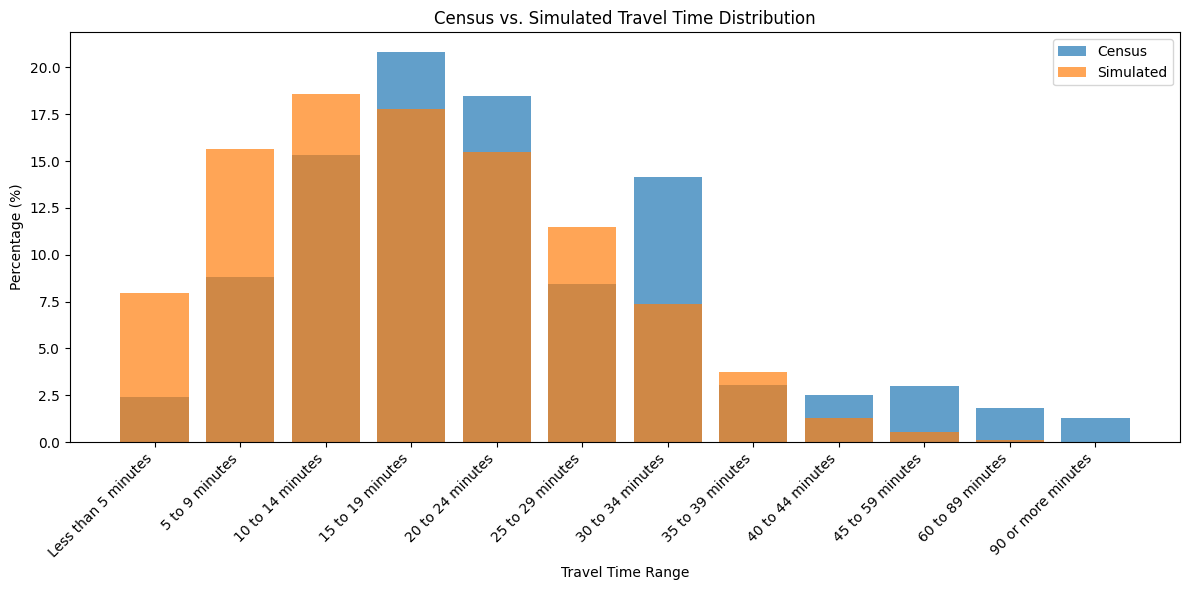

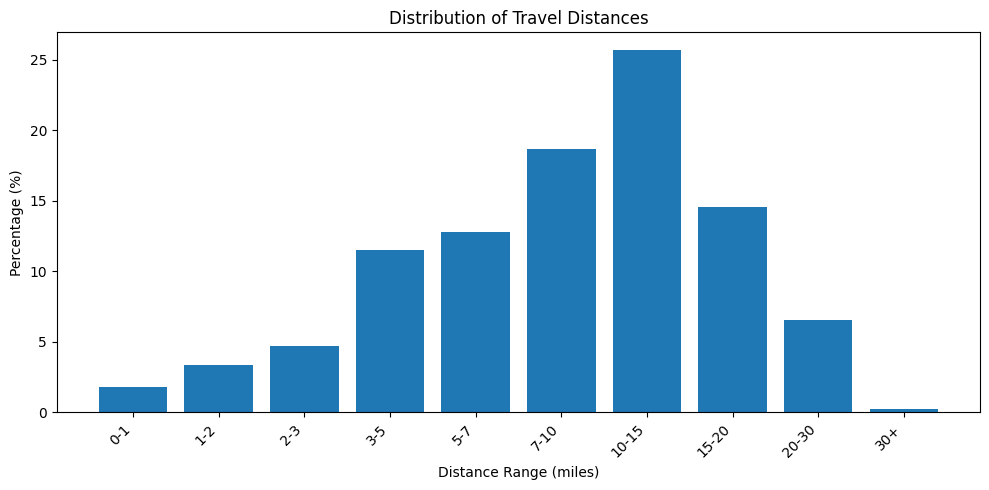

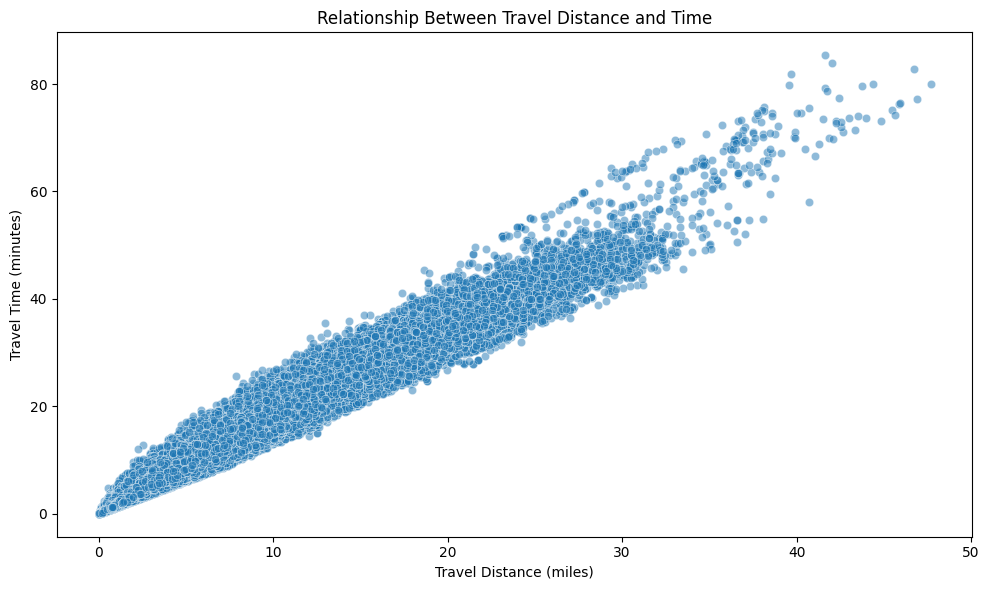

In [70]:
# Analyze distribution of distances alongside travel times

# First, let's create bins for distances (in miles)
distance_bins = [0, 1, 2, 3, 5, 7, 10, 15, 20, 30, float('inf')]
distance_labels = ['0-1', '1-2', '2-3', '3-5', '5-7', '7-10', '10-15', '15-20', '20-30', '30+']

# Bin the routing results by distance
routing_df['Distance_Category'] = pd.cut(
    routing_df['travel_distance_mi'], 
    bins=distance_bins, 
    labels=distance_labels, 
    right=False
)

# Create a distance distribution
distance_distribution = routing_df['Distance_Category'].value_counts().sort_index()
distance_percentage = (distance_distribution / len(routing_df) * 100).round(2)

# Create a DataFrame for the distance distribution
distance_df = pd.DataFrame({
    'Distance_Range_Miles': distance_labels,
    'Count': distance_distribution.values,
    'Percentage': distance_percentage.values
})

# Now create a cross-tabulation of time vs. distance
time_distance_matrix = pd.crosstab(
    routing_df['Time_Category'], 
    routing_df['Distance_Category'], 
    normalize='all'
) * 100

# Calculate average speed for each time-distance combination
routing_df['Speed_MPH'] = routing_df['travel_distance_mi'] / (routing_df['travel_time_min'] / 60)

# Group by time category and calculate average speed
speed_by_time = routing_df.groupby('Time_Category')['Speed_MPH'].mean().round(1)

# Group by distance category and calculate average speed
speed_by_distance = routing_df.groupby('Distance_Category')['Speed_MPH'].mean().round(1)

# Compare travel time distributions
# Extract lower bounds of time ranges for plotting
import re

def extract_min_time(time_range):
    if 'Less than' in time_range:
        return 0
    elif 'or more' in time_range:
        return int(re.findall(r'\d+', time_range)[0])
    else:
        return int(re.findall(r'\d+', time_range)[0])

# Add min time column for sorting
# Safely extract the minimum time from the time range and sort the dataframe
def extract_min_time(time_range):
    nums = re.findall(r'\d+', time_range)
    if 'Less than' in time_range:
        return 0
    elif 'or more' in time_range:
        return int(nums[0]) if nums else 0
    else:
        return int(nums[0]) if nums else 0

travel_time_df['Min_Time'] = travel_time_df['Time_Range'].apply(extract_min_time)
travel_time_df = travel_time_df.sort_values('Min_Time')

# Prepare comparison with Census data
comparison_with_distance = pd.DataFrame({
    'Time_Range': travel_time_df['Time_Range'][1:].values,  # Skip 'Total'
    'Census_Percentage': travel_time_df['Percentage'][1:].values,  # Skip 'Total'
    'Simulated_Percentage': simulated_percentage.values,
    'Avg_Distance_Mi': routing_df.groupby('Time_Category')['travel_distance_mi'].mean().round(2).values,
    'Avg_Speed_MPH': speed_by_time.values
})

# Print results
# print("Distribution of travel distances:")
# print(distance_df)
# print("\nCross-tabulation of travel time vs. distance (percentages):")
# print(time_distance_matrix.round(1))
# print("\nComparison with Census data, including average distances and speeds:")
# print(comparison_with_distance)

# # Visualization (optional - uncomment if needed)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot travel time distribution comparison
plt.figure(figsize=(12, 6))
plt.bar(comparison_with_distance['Time_Range'], comparison_with_distance['Census_Percentage'], 
        alpha=0.7, label='Census')
plt.bar(comparison_with_distance['Time_Range'], comparison_with_distance['Simulated_Percentage'], 
        alpha=0.7, label='Simulated')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Travel Time Range')
plt.ylabel('Percentage (%)')
plt.legend()
plt.title('Census vs. Simulated Travel Time Distribution')
plt.tight_layout()
plt.show()

# Plot distance distribution
plt.figure(figsize=(10, 5))
plt.bar(distance_df['Distance_Range_Miles'], distance_df['Percentage'])
plt.xlabel('Distance Range (miles)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Travel Distances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot relationship between distance and time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=routing_df, x='travel_distance_mi', y='travel_time_min', alpha=0.5)
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Travel Time (minutes)')
plt.title('Relationship Between Travel Distance and Time')
plt.tight_layout()
plt.show()


## Checks

In [71]:
import ast

def origin_in_possible_home(row):
    # Extract the origin location as a tuple
    origin = (row['origin_loc_lat'], row['origin_loc_lon'])
    # Ensure possible_home_loc is a list (if it's a string, convert it)
    possible_home = row['possible_home_loc']
    if isinstance(possible_home, str):
        possible_home = ast.literal_eval(possible_home)
    # Convert each entry in possible_home to a tuple for comparison
    possible_home_tuples = [tuple(loc) for loc in possible_home]
    return origin in possible_home_tuples

def dest_in_possible_dests(row):
    dest = (row['dest_loc_lat'], row['dest_loc_lon'])
    possible_home = row['possible_dest_loc']
    if isinstance(possible_home, str):
        possible_home = ast.literal_eval(possible_home)
    # Convert each entry in possible_home to a tuple for comparison
    possible_home_tuples = [tuple(loc) for loc in possible_home]
    return dest in possible_home_tuples

od_df['origin_in_possible_home'] = od_df.apply(origin_in_possible_home, axis=1)
od_df['dest_in_possible_dests'] = od_df.apply(dest_in_possible_dests, axis=1)

In [72]:
# Group by h_geocode and w_geocode
grouped = od_df.groupby(['h_geocode', 'w_geocode'])

# Function to check if all possible_dest_loc arrays in a group are identical
def check_identical_dests(group):
    # Convert each list of lists to a string representation for comparison
    # (directly comparing nested lists can be tricky)
    dest_strings = [str(sorted([tuple(dest) for dest in row])) for row in group['possible_dest_loc']]
    
    # Check if all are the same
    return len(set(dest_strings)) == 1

# Apply the check to each group
identical_dests_by_group = {}
for (h_code, w_code), group in grouped:
    identical_dests_by_group[(h_code, w_code)] = check_identical_dests(group)

# Count how many have identical destinations
identical_count = sum(identical_dests_by_group.values())
total_groups = len(identical_dests_by_group)

print(f"{identical_count} out of {total_groups} h_geocode, w_geocode pairs have identical possible_dest_loc lists")
print(f"Percentage: {100 * identical_count / total_groups:.2f}%")

# If you want to see groups with non-identical destinations
non_identical_groups = [(h_w, identical) for h_w, identical in identical_dests_by_group.items() if not identical]
if non_identical_groups:
    print("\nSample of groups with non-identical destinations:")
    for i, (h_w, _) in enumerate(non_identical_groups[:5]):  # Show first 5 examples
        h_code, w_code = h_w
        print(f"Group {i+1}: h_geocode={h_code}, w_geocode={w_code}")
        group = grouped.get_group((h_code, w_code))
        print(f"  Number of different records: {len(group)}")
        # Show the first few destinations from the first two records for comparison
        if len(group) >= 2:
            sample1 = group.iloc[0]['possible_dest_loc']
            sample2 = group.iloc[1]['possible_dest_loc']
            print(f"  First few destinations from record 1: {sample1[:2]}")
            print(f"  First few destinations from record 2: {sample2[:2]}")
        print()

24753 out of 24753 h_geocode, w_geocode pairs have identical possible_dest_loc lists
Percentage: 100.00%


## Calibration

In [14]:
census_travel_time_df = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/census_data/travel_time_to_work.csv', index_col=0)

census_df = census_travel_time_df.copy()

time_bins_columns = [
    'under_5_minutes_estimate', '5_to_9_minutes_estimate',
    '10_to_14_minutes_estimate', '15_to_19_minutes_estimate',
    '20_to_24_minutes_estimate', '25_to_29_minutes_estimate',
    '30_to_34_minutes_estimate', '35_to_39_minutes_estimate',
    '40_to_44_minutes_estimate', '45_to_59_minutes_estimate',
    '60_to_89_minutes_estimate', '90_minutes_and_over_estimate'
]

# Create structured census_targets dict
census_targets = {}
for _, row in census_df.iterrows():
    geo_id = row['GEO_ID']
    total_estimate = row['total_estimate']
    if total_estimate == 0:
        continue  # skip no data
    census_targets[geo_id] = {col: row[col]/total_estimate for col in time_bins_columns}


census_bin_edges = [0,5,10,15,20,25,30,35,40,45,60,90,float('inf')]
census_bin_labels = time_bins_columns

In [15]:
od_total_jobs = od_df.groupby(['h_geocode', 'w_geocode']).count()['total_jobs'].reset_index()
cbg_pairs = od_df.drop_duplicates(subset=['h_geocode', 'w_geocode'])[['h_geocode', 'w_geocode']]
cbg_pairs = cbg_pairs.merge(od_total_jobs, on=['h_geocode', 'w_geocode'])

In [16]:
# import pandas as pd
# import numpy as np

# def calculate_travel_time(row):
#     """Calculate travel time directly using hourly_graphs."""
#     try:
#         # Get departure time and round to the closest 30-min interval
#         departure_time = pd.Timestamp(row['departure_time'])
#         # Find the closest time key in hourly_graphs 
#         time_diff = {hr: abs(hr - departure_time) for hr in hourly_graphs.keys()}
#         closest_hour = min(time_diff, key=time_diff.get)
        
#         # Get the graph for this time period
#         G = hourly_graphs[closest_hour]
        
#         # Get origin and destination nodes
#         origin_node = row['origin_node']
#         destination_node = row['destination_node']
        
#         # Calculate the shortest path
#         route = nx.shortest_path(G, origin_node, destination_node, weight='weight')
        
#         # Sum the travel time (weights) along the path
#         travel_time_sec = sum(
#             G[u][v][0].get('weight', 0) 
#             for u, v in zip(route[:-1], route[1:])
#         )
        
#         # Convert to minutes
#         return travel_time_sec / 60
        
#     except (nx.NetworkXNoPath, KeyError, Exception) as e:
#         return np.nan

# # Apply the function to each row
# od_df['travel_time_inrix'] = od_df.apply(calculate_travel_time, axis=1)

In [17]:
def get_census_target(row):
    geo_id = row['origin_cbg']
    bin_label = row['census_bin']
    return census_targets.get(geo_id, {}).get(bin_label, 0)

In [18]:
import pandas as pd
import numpy as np
import ast
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm

def expand_od_candidates(od_df, hourly_graphs, departure_interval=3600):
    records = []
    
    # Get a reference graph for nearest node lookups
    G_0 = list(hourly_graphs.values())[0]
    
    # Map time bins to hourly graphs
    time_bin_to_graph = {}
    for hour, graph in hourly_graphs.items():
        # Convert hour to seconds since midnight
        hour_seconds = (hour.hour * 3600) + (hour.minute * 60) + hour.second
        bin_number = hour_seconds // departure_interval
        time_bin_to_graph[bin_number] = graph
    
    for _, row in tqdm(od_df.iterrows(), total=len(od_df), desc="Expanding OD candidates"):
        origin_cbg = row['h_geocode']
        destination_cbg = row['w_geocode']
        departure_time = row['departure_time_secs']
        departure_time_bin = departure_time // departure_interval
        
        # Get the appropriate graph for this time bin
        G = time_bin_to_graph.get(departure_time_bin, G_0)  # Fallback to G_0 if time bin not found
        
        # Parse possible origins and destinations
        origin_nodes = row['possible_home_nodes']
        dest_nodes = row['possible_dest_nodes']
        
        if isinstance(origin_nodes, str):
            origin_nodes = ast.literal_eval(origin_nodes)
        if isinstance(dest_nodes, str):
            dest_nodes = ast.literal_eval(dest_nodes)
            
        # Calculate travel times directly using the graph
        for o_node in origin_nodes:
            for d_node in dest_nodes:
                try:
                    # Calculate shortest path
                    route = nx.shortest_path(G, o_node, d_node, weight='weight')
                    
                    # Sum edge weights to get travel time in seconds
                    travel_time_sec = sum(G[u][v][0].get('weight', 0) 
                                         for u, v in zip(route[:-1], route[1:]))
                    
                    # Convert to minutes
                    travel_time_min = travel_time_sec / 60
                    
                    records.append({
                        'origin_cbg': origin_cbg,
                        'destination_cbg': destination_cbg,
                        'origin_node': o_node,
                        'destination_node': d_node,
                        'departure_time_bin': departure_time_bin,
                        'travel_time': travel_time_min
                    })
                except (nx.NetworkXNoPath, KeyError) as e:
                    # No path found or other error - skip this pair
                    continue
    
    return pd.DataFrame(records)

# Example usage:
# expanded_df = expand_od_candidates(od_df, hourly_graphs)

In [ ]:
import pandas as pd
import numpy as np
import ast
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
import multiprocessing as mp

def map_hour_to_time_bin(hourly_graphs, departure_interval=1800):
    """Map hourly graphs to time bins"""
    time_bin_to_hour = {}
    hour_to_time_bin = {}
    
    for hour in hourly_graphs.keys():
        # Convert hour to seconds since midnight
        hour_seconds = (hour.hour * 3600) + (hour.minute * 60) + hour.second
        bin_number = hour_seconds // departure_interval
        
        time_bin_to_hour[bin_number] = hour
        hour_to_time_bin[hour] = bin_number
    
    return time_bin_to_hour, hour_to_time_bin

def process_time_bin(args):
    """
    Process all OD pairs for a specific time bin
    """
    time_bin, bin_df, hourly_graphs, time_bin_to_hour, departure_interval = args
    
    records = []
    hour = time_bin_to_hour.get(time_bin)
    
    # Skip if no matching hour
    if hour is None:
        print(f"No matching hour for time bin {time_bin}")
        return records
    
    # Get the graph for this hour
    G = hourly_graphs.get(hour)
    if G is None:
        print(f"No graph for hour {hour}")
        return records
    
    print(f"Processing time bin {time_bin} (hour {hour}): {len(bin_df)} rows")
    
    # Process each row in this time bin
    for _, row in bin_df.iterrows():
        origin_cbg = row['h_geocode']
        destination_cbg = row['w_geocode']
        
        # Parse possible origins and destinations
        origin_nodes = row['possible_home_nodes']
        dest_nodes = row['possible_dest_nodes']
        
        if isinstance(origin_nodes, str):
            origin_nodes = ast.literal_eval(origin_nodes)
        if isinstance(dest_nodes, str):
            dest_nodes = ast.literal_eval(dest_nodes)
            
        # Calculate travel times using the graph for this time bin

        print(f"Total combinations: {len(origin_nodes) * len(dest_nodes)}")
        for o_node in origin_nodes:
            for d_node in dest_nodes:
                try:
                    # Calculate shortest path
                    route = nx.shortest_path(G, o_node, d_node, weight='weight')
                    
                    # Sum edge weights to get travel time in seconds
                    travel_time_sec = sum(G[u][v][0].get('weight', 0) 
                                         for u, v in zip(route[:-1], route[1:]))
                    
                    # Convert to minutes
                    travel_time_min = travel_time_sec / 60
                    
                    records.append({
                        'origin_cbg': origin_cbg,
                        'destination_cbg': destination_cbg,
                        'origin_node': o_node,
                        'destination_node': d_node,
                        'departure_time_bin': time_bin,
                        'travel_time': travel_time_min
                    })
                except (nx.NetworkXNoPath, KeyError) as e:
                    # No path found or other error - skip this pair
                    continue
    
    print(f"Time bin {time_bin}: Generated {len(records)} records")
    return records

def expand_od_candidates_by_timebin(od_df, hourly_graphs, departure_interval=3600, n_jobs=None):
    """
    Group by time bins and process each bin in parallel
    """
    # Set number of worker processes
    if n_jobs is None:
        n_jobs = max(1, min(mp.cpu_count() - 1, len(hourly_graphs)))
    
    print(f"Using up to {n_jobs} worker processes")
    
    # Create mappings between time bins and hours
    time_bin_to_hour, hour_to_time_bin = map_hour_to_time_bin(hourly_graphs, departure_interval)
    
    # Add departure time bin column
    od_df['departure_time_bin'] = od_df['departure_time_secs'] // departure_interval
    
    # Group by departure time bin
    grouped = od_df.groupby('departure_time_bin')
    
    # Get list of all time bins with data
    time_bins = list(grouped.groups.keys())
    print(f"Found {len(time_bins)} unique departure time bins")
    
    # Prepare arguments for each worker process
    args_list = [
        (time_bin, grouped.get_group(time_bin), hourly_graphs, time_bin_to_hour, departure_interval)
        for time_bin in time_bins if time_bin in time_bin_to_hour
    ]
    
    print(f"Processing {len(args_list)} time bins with matching hourly graphs")
    
    # Process time bins in parallel
    all_records = []
    
    with mp.Pool(min(n_jobs, len(args_list))) as pool:
        with tqdm(total=len(args_list), desc="Processing time bins") as pbar:
            for result in pool.imap(process_time_bin, args_list):
                all_records.extend(result)
                pbar.update(1)
                pbar.set_postfix({"records": len(all_records)})
    
    print(f"Completed parallel processing. Generated {len(all_records)} total records.")
    return pd.DataFrame(all_records)

# Example usage:
# expanded_df = expand_od_candidates_by_timebin(od_df, hourly_graphs)

In [20]:
def assign_bins_and_targets(df, bin_edges, bin_labels, census_target_lookup):
    df = df.copy()
    df['census_bin'] = pd.cut(df['travel_time'], bins=bin_edges, labels=bin_labels, right=False)
    df['initial_weight'] = 1 / len(df)

    def get_target(row):
        return census_target_lookup.get(row['origin_cbg'], {}).get(row['census_bin'], 0)

    df['census_target'] = df.apply(get_target, axis=1)
    return df

In [21]:
from tqdm import tqdm
import cvxpy as cp

def calibrate_weights(calibration_df, lambda_reg=1.0):
    calibrated_sub_dfs = []
    calibration_df = calibration_df.dropna(subset=['travel_time', 'census_target'])

    for origin_cbg, group in tqdm(calibration_df.groupby('origin_cbg'), desc="Calibrating per origin"):
        n = len(group)
        if n == 0:
            continue

        x = cp.Variable(n, nonneg=True)
        unique_bins = group['census_bin'].unique()
        bin_indices = {b: group[group['census_bin'] == b].index.tolist() for b in unique_bins}
        e_plus = cp.Variable(len(unique_bins), nonneg=True)
        e_minus = cp.Variable(len(unique_bins), nonneg=True)

        constraints = [cp.sum(x) == 1]
        for i, b in enumerate(unique_bins):
            idxs = group.index.get_indexer(bin_indices[b])
            if len(idxs) == 0:
                continue
            census_prop = group.loc[bin_indices[b][0], 'census_target']
            constraints.append(cp.sum(x[idxs]) - census_prop == e_plus[i] - e_minus[i])

        initial_w = group['initial_weight'].values
        objective = cp.Minimize(cp.sum(e_plus + e_minus) + lambda_reg * cp.norm1(x - initial_w))

        prob = cp.Problem(objective, constraints)
        try:
            prob.solve(solver=cp.ECOS, verbose=False)
        except cp.error.SolverError:
            continue

        group = group.copy()
        group['optimized_weight'] = x.value if x.value is not None else np.nan
        calibrated_sub_dfs.append(group)

    return pd.concat(calibrated_sub_dfs, ignore_index=True)


In [22]:
def sample_calibrated_od(calibrated_df):
    sampled = []
    
    grouped = calibrated_df.groupby(
        ['origin_cbg', 'destination_cbg', 'departure_time_bin']
    )
    for _, group in tqdm(
        grouped, total=grouped.ngroups, desc="Sampling calibrated OD"
    ):
        probs = group['optimized_weight'].fillna(0).values
        probs /= probs.sum() if probs.sum() > 0 else 1

        idx = np.random.choice(group.index, p=probs)
        sampled.append(group.loc[idx])

    return pd.DataFrame(sampled)

In [ ]:
def run_full_calibration_pipeline(od_df, hourly_graphs, census_targets, departure_interval=3600):
    print("🔁 Expanding OD candidates...")
    # expanded_df = expand_od_candidates(od_df, hourly_graphs, departure_interval)
    expanded_df = expand_od_candidates_by_timebin(od_df, hourly_graphs, departure_interval)
    expanded_df.to_parquet('expanded_df.parquet')
    
    print("🧮 Assigning travel-time bins and census targets...")
    expanded_df = assign_bins_and_targets(expanded_df, census_bin_edges, census_bin_labels, census_targets)

    print("📉 Solving LPs for calibration...")
    calibrated_df = calibrate_weights(expanded_df)

    print("🎲 Sampling final calibrated OD locations...")
    final_sampled = sample_calibrated_od(calibrated_df)

    return final_sampled


In [ ]:
import cvxpy as cp

optimized_weights_list = []

for origin_cbg, df_origin in calibration_df.groupby('origin_cbg'):
    x = cp.Variable(len(df_origin), nonneg=True)

    # Slack variables for each bin
    bins = df_origin['census_bin'].unique()
    e_plus = cp.Variable(len(bins), nonneg=True)
    e_minus = cp.Variable(len(bins), nonneg=True)

    # Regularization parameter
    lambda_reg = 1.0

    # Objective
    objective = cp.Minimize(
        cp.sum(e_plus + e_minus) + lambda_reg * cp.norm1(x - df_origin['initial_weight'].values)
    )

    # Constraints
    constraints = [
        cp.sum(x) == 1  # Exactly one trip per origin CBG (or normalize accordingly)
    ]

    # Bin constraints
    for idx, bin_label in enumerate(bins):
        bin_indices = df_origin[df_origin['census_bin'] == bin_label].index
        census_prop = df_origin.loc[bin_indices[0], 'census_target']
        constraints.append(
            (cp.sum(x[df_origin.index.get_indexer(bin_indices)]) / cp.sum(x)) - census_prop == e_plus[idx] - e_minus[idx]
        )

    # Solve LP
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Store optimized weights
    df_origin = df_origin.copy()
    df_origin['optimized_weight'] = x.value
    optimized_weights_list.append(df_origin)

# Combine results
calibrated_df = pd.concat(optimized_weights_list, ignore_index=True)


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
Sum(var1[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], None, False) / Sum(var1, None, False) + -0.22540983606557377 == var2[0] + -var3[0] , because the following subexpressions are not:
|--  Sum(var1[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], None, False) / Sum(var1, None, False)
Sum(var1[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 61, 62, 63, 64, 65, 66, 70, 71], None, False) / Sum(var1, None, False) + -0.11557377049180328 == var2[1] + -var3[1] , because the following subexpressions are not:
|--  Sum(var1[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 61, 62, 63, 64, 65, 66, 70, 71], None, False) / Sum(var1, None, False)
Sum(var1[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], None, False) / Sum(var1, None, False) + -0.13524590163934427 == var2[2] + -var3[2] , because the following subexpressions are not:
|--  Sum(var1[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], None, False) / Sum(var1, None, False)
Sum(var1[60, 67, 68, 69], None, False) / Sum(var1, None, False) + -0.31475409836065577 == var2[3] + -var3[3] , because the following subexpressions are not:
|--  Sum(var1[60, 67, 68, 69], None, False) / Sum(var1, None, False)

In [ ]:
import numpy as np
import pandas as pd

calibrated_df['normalized_weight'] = calibrated_df.groupby('origin_cbg')['optimized_weight'].transform(
    lambda x: x / x.sum()
)

final_calibrated_records = []

for origin_cbg, group in calibrated_df.groupby('origin_cbg'):
    probabilities = group['normalized_weight'].values
    sample_size = len(group)  # Typically, number of individuals you initially had or a known total per origin_cbg

    sampled_indices = np.random.choice(
        group.index,
        size=sample_size,
        replace=True,  # Replace=True to match distribution exactly; False if unique required
        p=probabilities
    )
    
    sampled_group = group.loc[sampled_indices]
    final_calibrated_records.append(sampled_group)

# Combine all sampled OD–S trips into a final DataFrame
final_calibrated_od_df = pd.concat(final_calibrated_records, ignore_index=True)

final_distribution = final_calibrated_od_df.groupby(['origin_cbg', 'census_bin']).size().unstack(fill_value=0)
final_distribution_normalized = final_distribution.div(final_distribution.sum(axis=1), axis=0)

print("Final calibrated OD–S travel-time distribution per origin:")
final_distribution_normalized

## test

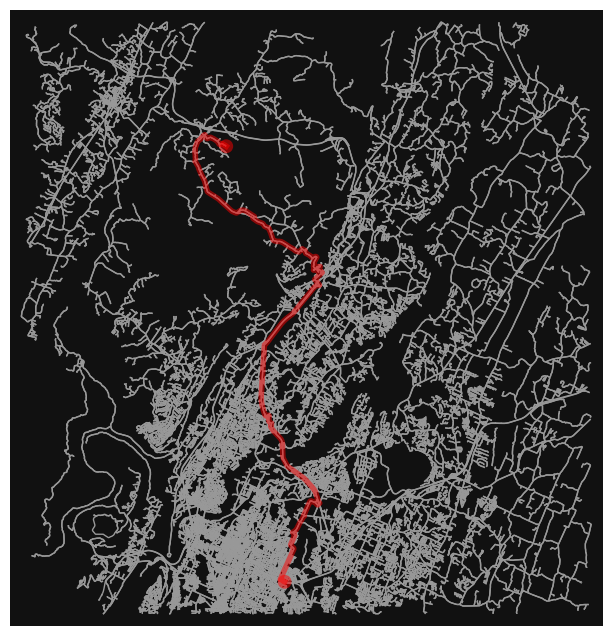

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [81]:
orig_lat, orig_lon = 35.0050, -85.2270
dest_lat, dest_lon = 35.3380, -85.2750

orig_node = ox.distance.nearest_nodes(G, X=orig_lon, Y=orig_lat)
dest_node = ox.distance.nearest_nodes(G, X=dest_lon, Y=dest_lat)

# Compute shortest path using real-time weights
route = nx.shortest_path(G, source=orig_node, target=dest_node, weight='weight')

# Visualize
ox.plot_graph_route(G, route, route_linewidth=4, node_size=0)

In [82]:
route_edges_info = []

for u, v in zip(route[:-1], route[1:]):
    data = G[u][v][0]  # Assuming key=0; use correct key if multi-graph
    length = data.get('length', None)
    weight = data.get('weight', None)
    
    route_edges_info.append({
        'from': u,
        'to': v,
        'length_m': length,
        'weight_sec': weight
    })

# Optional: Convert to DataFrame
import pandas as pd
route_edges_df = pd.DataFrame(route_edges_info)

# Display summary
print("\nTotal edges in route:", len(route_edges_df))
print("Total travel time (min):", route_edges_df['weight_sec'].sum() / 60)


Total edges in route: 147
Total travel time (min): 65.51705019508226
